In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pingouin import kruskal
import scikit_posthocs as sp
import os

In [163]:
parser = argparse.ArgumentParser(description='GC_content_plots')
parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
parser.add_argument('GC_content_tsv', type=str, help='Input location of promoters GC_content tsv file')


NameError: name 'argparse' is not defined

In [164]:
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
GC_content_tsv = f'../../data/output/{file_names}/GC_content/promoters_5UTR_GC_content.tsv'
dependent_variable = 'GC_content'


In [165]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/GC_content/plots  already exists


In [166]:
def read_GC_file(GC_content_tsv):
    """read in GC file and make extra columns"""
     #read in GC content tsv
    GC_content = pd.read_table(GC_content_tsv, sep='\t', header=None)
    cols2 = ['name', 'percentage_GC_content']
    GC_content.columns = cols2

    #Make AGI column
    GC_content['AGI'] = GC_content.name.str.split(':',expand=True)[0]
    #make window number column
    #GC_content = GC_content.assign(window_number=GC_content.name.str.extract(r'_(.*?)\:'))
    #make chr column
    GC_content = GC_content.assign(chr=GC_content.name.str.split(':',n=3,expand=True)[2])
    #make start column
    GC_content = GC_content.assign(start=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[0])
    #make stop column
    GC_content = GC_content.assign(stop=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[1])
    return GC_content
    

In [167]:
def mergeGC_genecategories(GC_content_df, gene_categories):
    """merged GC content df with gene categories"""
    #read in gene categories
    gene_cats = pd.read_csv(gene_categories,sep='\t', header=None)
    gene_cats.columns = ['AGI','gene_type']
    #merge to limit to genes of interest
    GC_content_categories = pd.merge(gene_cats, GC_content_df, how='left', on='AGI')
    return GC_content_categories

In [168]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    plot = sns.catplot(x=x_variable, y=y_variable, data=df, kind=plot_kind)
    #plot points
    ax = sns.swarmplot(x=x_variable, y=y_variable, data=df, color=".25")
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [169]:
# def box_plot(GC_content_categories, x_variable, y_variable,x_label, y_label,output_prefix):
#     """function to make and save box plot of GC_content split by gene_categories"""
#     #allow colour codes in seaborn
#     sns.set(color_codes=True)
#     sns.set_style("whitegrid")
#     #plot
#     plot = sns.catplot(x=x_variable, y=y_variable, data=GC_content_categories,kind='box')
#     #plot points
#     ax = sns.swarmplot(x=x_variable, y=y_variable, data=GC_content_categories, color=".25")
#     plt.ylabel('Percentage GC content')
#     plt.xlabel('Gene type')
#     #save figure
#     ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/plots/{output_prefix}_box.pdf', format='pdf')
    


In [170]:
def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters GC content"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/plots/{output_prefix}_distribution.pdf', format='pdf')    

In [171]:
#read GC file
GC_content_df = read_GC_file(GC_content_tsv)
#merge with promoter categories
GC_content_Czechowski_gene_categories = mergeGC_genecategories(GC_content_df, Czechowski_gene_categories)

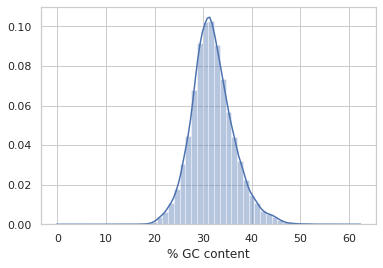

In [172]:
#all promoter distribution plot
all_prom_distribution(GC_content_df,'percentage_GC_content', '% GC content', f'{dependent_variable}_allproms')

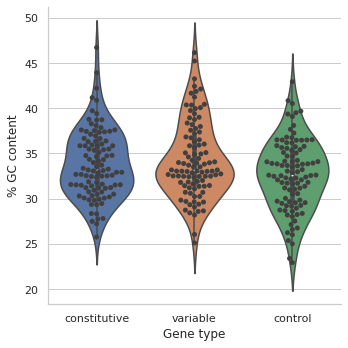

In [173]:
#Czechowski_gene_categories violin plot
make_plot(GC_content_Czechowski_gene_categories,'gene_type','percentage_GC_content','Gene type','% GC content', f'Czechowski_{dependent_variable}', 'violin')

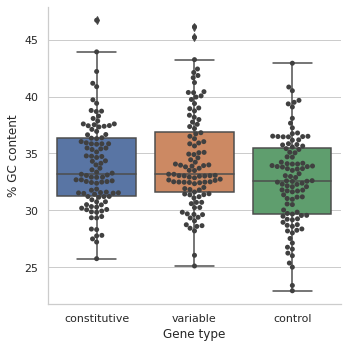

In [174]:
#Czechowski_gene_categories box plot
make_plot(GC_content_Czechowski_gene_categories,'gene_type','percentage_GC_content','Gene type','% GC content', f'Czechowski_{dependent_variable}', 'box')

In [175]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [176]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [177]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [178]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)
    

In [179]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [180]:
df = GC_content_Czechowski_gene_categories
dependent_variable = 'percentage_GC_content'
between_variable = 'gene_type'

In [181]:
test_normality(df,dependent_variable,between_variable)

constitutive: (0.9779946208000183, 0.09265118092298508)
variable: (0.966627836227417, 0.01227493118494749)
control: (0.9950302839279175, 0.9759314656257629)


### not normal

In [182]:
variance(df,dependent_variable,between_variable)

LeveneResult(statistic=0.13769481659999006, pvalue=0.871420170690621)

### fail to reject null hypothesis that variances are equal

In [183]:
#descriptive stats
describe_stats(df,dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,33.874180,3.789410,25.746653,31.216253,33.221018,36.356730,46.721311
control,100.0,32.669495,3.912815,22.922135,29.708866,32.600644,35.463181,42.941176
variable,100.0,34.308940,4.183845,25.103306,31.573916,33.174007,36.919429,46.153846


In [184]:
kruskal_test(df,dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,6.014818,0.04942


### significant difference, do post hoc tests

In [185]:
#run Dunn's post-hoc test
dunn_posthoc_test(df,dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,0.210501,1.00000
control,0.210501,-1.000000,0.05819
variable,1.000000,0.058190,-1.00000


### control significantly lower GC content than variable genes